# Grupo 60
1. Willian Fuertes Batista (RM363154)
2. Luiz Guilherme Paro (RM363159)

# Tech Challenge - Modelo Preditivo de Custos Médicos

Este notebook apresenta o desenvolvimento de um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde, conforme solicitado no Tech Challenge.

## Introdução

Neste projeto, vamos desenvolver um modelo preditivo para estimar os custos médicos individuais cobrados pelo seguro de saúde com base em características pessoais dos segurados. Este tipo de modelo é fundamental para as seguradoras de saúde, pois permite uma precificação mais justa e personalizada dos planos, além de auxiliar na gestão de riscos.

Seguiremos uma metodologia estruturada de ciência de dados, passando pelas seguintes etapas:
1. Exploração dos dados para entender suas características e distribuições
2. Pré-processamento para preparar os dados para modelagem
3. Modelagem com técnicas de regressão
4. Avaliação e validação estatística dos resultados

Ao final, teremos um modelo capaz de prever os custos médicos com base nas características dos segurados, além de insights valiosos sobre os fatores que mais influenciam esses custos.

In [36]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from scipy import stats

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuração para exibir todas as colunas
pd.set_option('display.max_columns', None)

## 1. Exploração de dados

A exploração de dados é uma etapa fundamental em qualquer projeto de ciência de dados. Nesta fase, vamos examinar detalhadamente o conjunto de dados para entender sua estrutura, identificar padrões, relações entre variáveis e possíveis problemas que precisem ser tratados antes da modelagem.

### 1.1 Base de dados e suas características

Começaremos carregando o dataset e examinando suas características básicas, como o número de registros, tipos de dados, presença de valores ausentes e distribuição das variáveis categóricas. Esta análise inicial nos dará uma visão geral dos dados com os quais estamos trabalhando.

In [37]:
# Carregamento do dataset
df = pd.read_csv('../data/dataset-tech-challenge.csv')

# Exibição das primeiras linhas do dataset
print('Primeiras 5 linhas do dataset:')
df.head()

Primeiras 5 linhas do dataset:


,idade,genero,imc,filhos,fumante,regiao,encargos
0,79,feminino,29.40,0,não,Sudeste,6282.86
1,38,feminino,26.54,0,não,Nordeste,2296.08
2,21,feminino,25.84,2,não,Sudeste,4028.91
3,70,feminino,35.46,0,não,Sudeste,7389.44
4,70,masculino,27.16,4,não,Norte,3549.79


In [38]:
# Informações gerais sobre o dataset
print('\nInformações gerais sobre o dataset:')
df.info()


Informações gerais sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     5000 non-null   int64  
 1   genero    5000 non-null   object 
 2   imc       5000 non-null   float64
 3   filhos    5000 non-null   int64  
 4   fumante   5000 non-null   object 
 5   regiao    5000 non-null   object 
 6   encargos  5000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 273.6+ KB


Acima, podemos observar as informações gerais do dataset, incluindo o número total de registros e os tipos de dados de cada coluna. É importante verificar se os tipos de dados estão corretos para cada variável, pois isso pode afetar as análises subsequentes. Por exemplo, variáveis numéricas devem estar em formatos numéricos (int64, float64), enquanto variáveis categóricas geralmente estão em formato de objeto (object).

In [39]:
# Verificação de valores ausentes
print('\nValores ausentes por coluna:')
df.isnull().sum()


Valores ausentes por coluna:


idade       0
genero      0
imc         0
filhos      0
fumante     0
regiao      0
encargos    0
dtype: int64

A verificação de valores ausentes é crucial, pois dados faltantes podem comprometer a qualidade do modelo. Felizmente, se não encontrarmos valores ausentes, não precisaremos implementar técnicas de imputação, o que simplifica nosso pré-processamento.

In [40]:
# Verificação de duplicatas
print(f'\nNúmero de linhas duplicadas: {df.duplicated().sum()}')


Número de linhas duplicadas: 0


Verificamos também a presença de registros duplicados, que poderiam enviesar nossas análises e o modelo final. Registros duplicados podem ocorrer por erros na coleta ou processamento dos dados e geralmente devem ser removidos.

In [41]:
# Análise das variáveis categóricas
print('\nDistribuição da variável "genero":')
print(df['genero'].value_counts())

print('\nDistribuição da variável "fumante":')
print(df['fumante'].value_counts())

print('\nDistribuição da variável "regiao":')
print(df['regiao'].value_counts())


Distribuição da variável "genero":
genero
feminino     2521
masculino    2479
Name: count, dtype: int64

Distribuição da variável "fumante":
fumante
não    3692
sim    1308
Name: count, dtype: int64

Distribuição da variável "regiao":
regiao
Sudeste         2069
Nordeste        1334
Sul              745
Norte            432
Centro-Oeste     420
Name: count, dtype: int64


Analisamos a distribuição das variáveis categóricas para entender a composição do dataset. Isso nos ajuda a identificar possíveis desequilíbrios nas categorias, o que pode afetar o desempenho do modelo. Por exemplo, se uma categoria tiver muito poucos exemplos, o modelo pode não aprender adequadamente os padrões associados a ela.

### 1.2 Análise estatísticas descritivas e visualizações relevantes

Agora, vamos aprofundar nossa análise com estatísticas descritivas e visualizações que nos ajudarão a entender melhor a distribuição das variáveis numéricas e as relações entre as variáveis preditoras e a variável alvo (encargos médicos).

In [42]:
# Estatísticas descritivas das variáveis numéricas
print('Estatísticas descritivas das variáveis numéricas:')
df.describe()

Estatísticas descritivas das variáveis numéricas:


,idade,imc,filhos,encargos
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,48.803200,27.965310,1.154000,8566.453906
std,18.232108,5.917962,1.251798,6874.276654
min,18.000000,15.000000,0.000000,500.000000
25%,33.000000,23.830000,0.000000,3757.657500
50%,48.000000,27.810000,1.000000,5521.205000
75%,65.000000,31.950000,2.000000,16283.290000
max,80.000000,50.000000,5.000000,26023.840000


As estatísticas descritivas nos fornecem uma visão geral das variáveis numéricas, incluindo média, desvio padrão, valores mínimos e máximos, e quartis. Isso nos ajuda a identificar possíveis outliers e entender a distribuição dos dados. Por exemplo, uma grande diferença entre a média e a mediana pode indicar uma distribuição assimétrica.

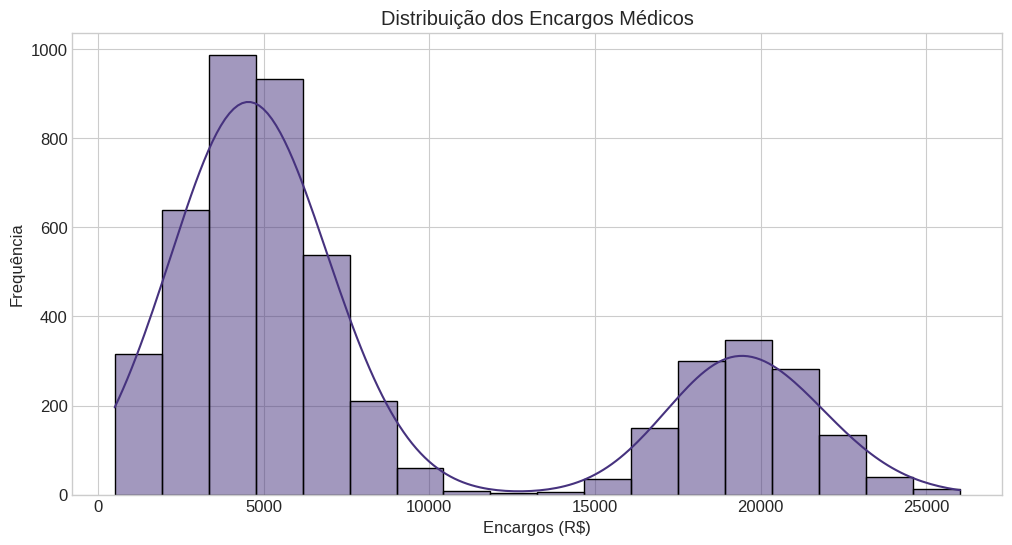

Assimetria da distribuição dos encargos: 0.96


In [43]:
# Visualização da distribuição da variável alvo (encargos)
plt.figure(figsize=(12, 6))
sns.histplot(df['encargos'], kde=True)
plt.title('Distribuição dos Encargos Médicos')
plt.xlabel('Encargos (R$)')
plt.ylabel('Frequência')
plt.show()

# Verificação de assimetria na distribuição dos encargos
print(f'Assimetria da distribuição dos encargos: {df["encargos"].skew():.2f}')

A visualização da distribuição da variável alvo (encargos) é crucial para entender como os custos médicos estão distribuídos na população. Uma distribuição assimétrica positiva (com cauda à direita) é comum em dados financeiros, indicando que a maioria das pessoas tem custos médicos relativamente baixos, enquanto uma minoria tem custos muito elevados. O valor de assimetria (skewness) quantifica essa característica, com valores positivos indicando assimetria à direita.

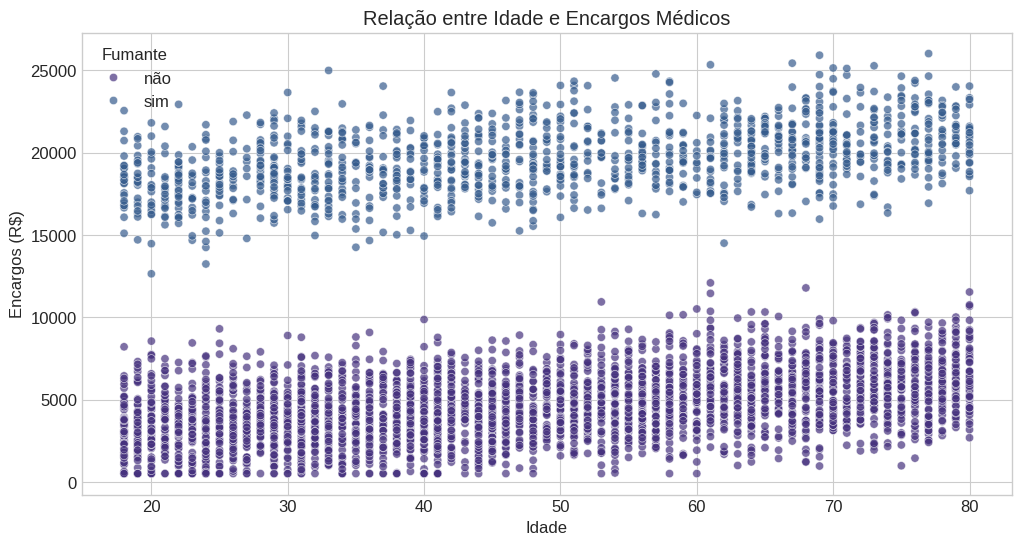

In [44]:
# Visualização da relação entre idade e encargos
plt.figure(figsize=(12, 6))
sns.scatterplot(x='idade', y='encargos', data=df, hue='fumante', alpha=0.7)
plt.title('Relação entre Idade e Encargos Médicos')
plt.xlabel('Idade')
plt.ylabel('Encargos (R$)')
plt.legend(title='Fumante')
plt.show()

Este gráfico de dispersão nos mostra a relação entre a idade dos segurados e seus encargos médicos, com pontos coloridos de acordo com o status de fumante. Podemos observar se existe uma tendência de aumento dos custos com a idade e se há diferenças significativas entre fumantes e não fumantes. Esta visualização pode revelar padrões importantes que o modelo deve capturar.

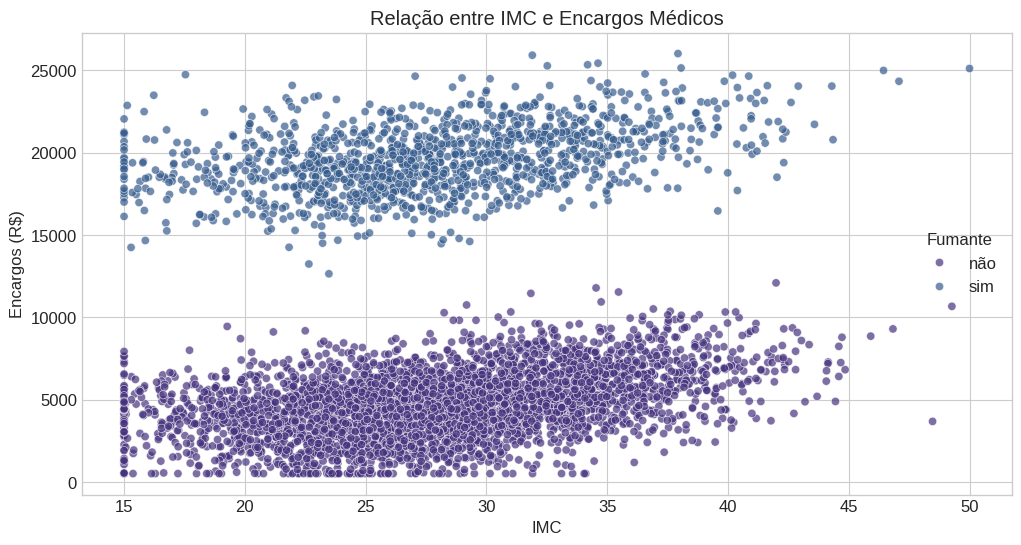

In [45]:
# Visualização da relação entre IMC e encargos
plt.figure(figsize=(12, 6))
sns.scatterplot(x='imc', y='encargos', data=df, hue='fumante', alpha=0.7)
plt.title('Relação entre IMC e Encargos Médicos')
plt.xlabel('IMC')
plt.ylabel('Encargos (R$)')
plt.legend(title='Fumante')
plt.show()

De forma similar, este gráfico mostra a relação entre o Índice de Massa Corporal (IMC) e os encargos médicos. O IMC é um indicador importante de saúde, e pessoas com IMC muito alto (obesidade) ou muito baixo (desnutrição) podem ter mais problemas de saúde e, consequentemente, custos médicos mais elevados. Novamente, a coloração por status de fumante nos permite visualizar o efeito combinado dessas variáveis.

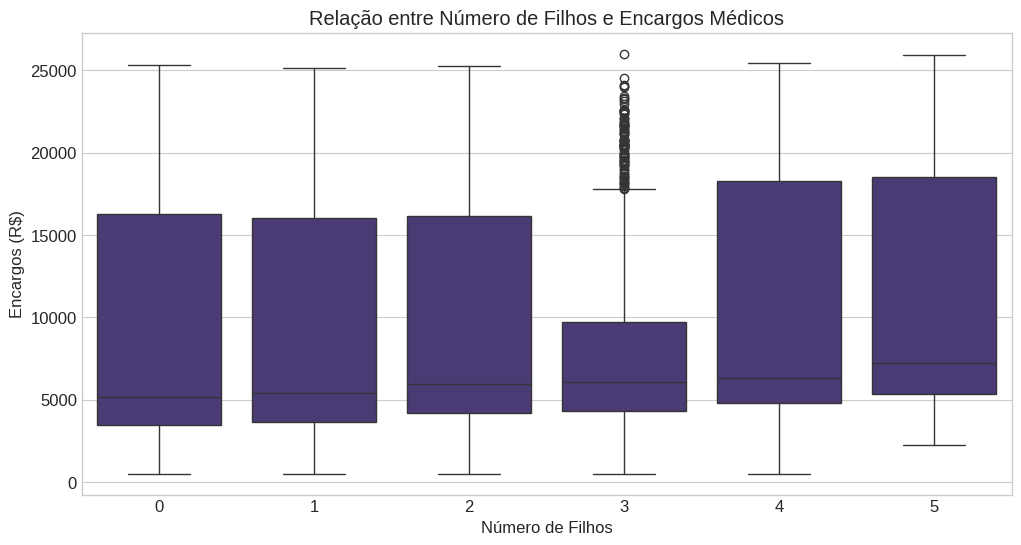

In [46]:
# Visualização da relação entre número de filhos e encargos
plt.figure(figsize=(12, 6))
sns.boxplot(x='filhos', y='encargos', data=df)
plt.title('Relação entre Número de Filhos e Encargos Médicos')
plt.xlabel('Número de Filhos')
plt.ylabel('Encargos (R$)')
plt.show()

Os boxplots acima mostram a distribuição dos encargos médicos para diferentes números de filhos. Cada caixa representa a distribuição dos encargos para um determinado número de filhos, com a linha central indicando a mediana, as bordas da caixa os quartis, e os "bigodes" a extensão dos dados (excluindo outliers, que são mostrados como pontos). Esta visualização nos ajuda a entender se o número de filhos tem alguma influência nos custos médicos.

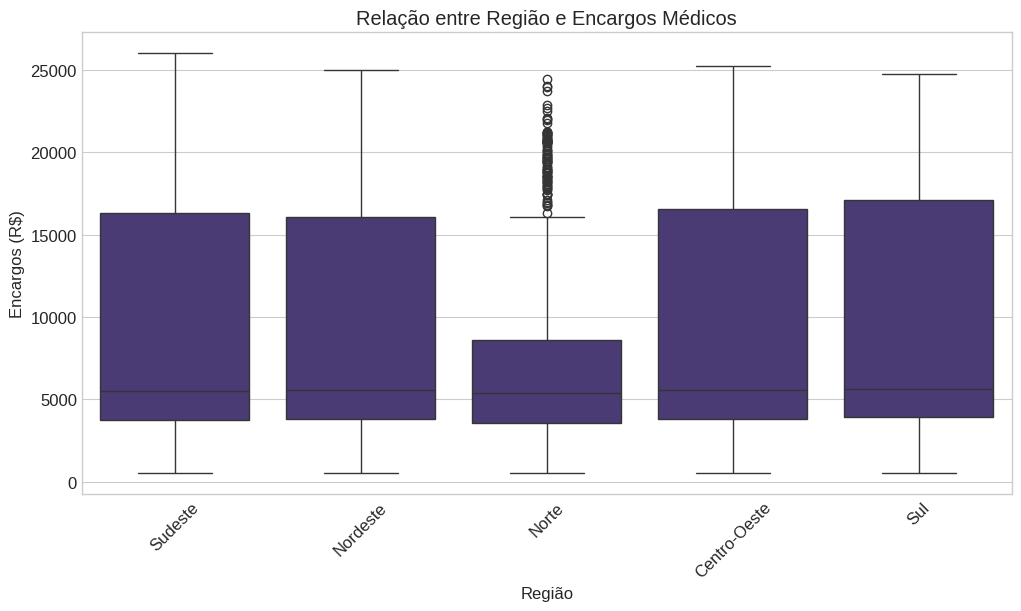

In [47]:
# Visualização da relação entre região e encargos
plt.figure(figsize=(12, 6))
sns.boxplot(x='regiao', y='encargos', data=df)
plt.title('Relação entre Região e Encargos Médicos')
plt.xlabel('Região')
plt.ylabel('Encargos (R$)')
plt.xticks(rotation=45)
plt.show()

Estes boxplots mostram a distribuição dos encargos médicos por região. Diferenças significativas entre regiões podem indicar variações no custo de vida, acesso a serviços de saúde, ou outros fatores regionais que afetam os custos médicos. Esta informação pode ser valiosa para seguradoras que operam em diferentes regiões do país.

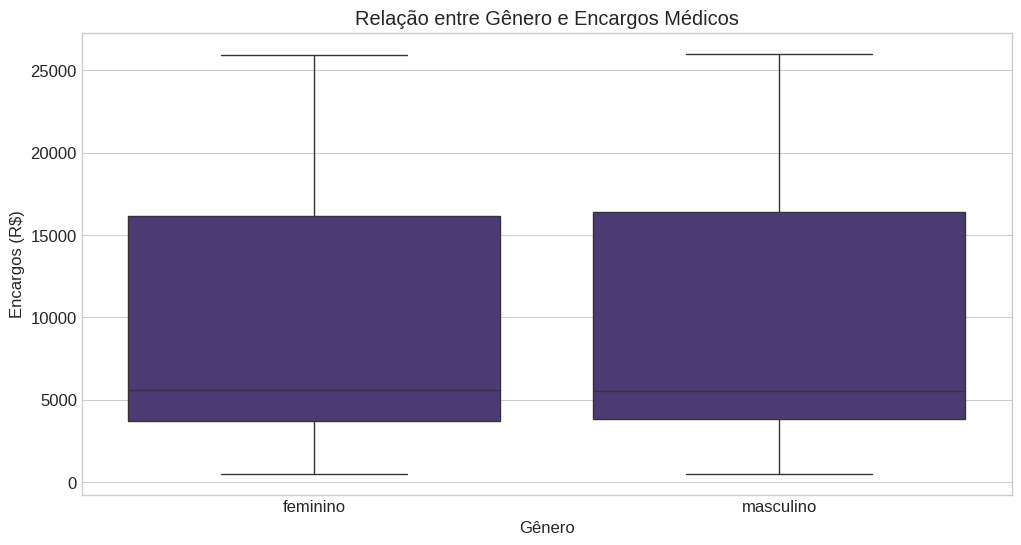

In [48]:
# Visualização da relação entre gênero e encargos
plt.figure(figsize=(12, 6))
sns.boxplot(x='genero', y='encargos', data=df)
plt.title('Relação entre Gênero e Encargos Médicos')
plt.xlabel('Gênero')
plt.ylabel('Encargos (R$)')
plt.show()

Aqui, analisamos se existe diferença nos encargos médicos entre os gêneros. Diferenças significativas podem refletir padrões de saúde distintos ou outras variáveis correlacionadas com o gênero. É importante notar que, em muitos países, as seguradoras são proibidas de discriminar preços com base no gênero, mas a informação ainda pode ser relevante para entender os padrões nos dados.

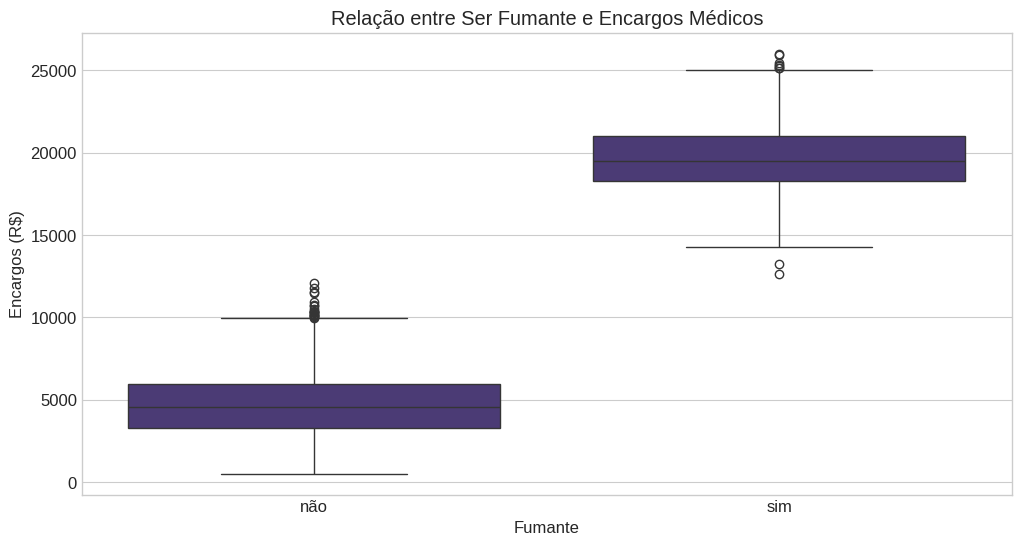

In [49]:
# Visualização da relação entre ser fumante e encargos
plt.figure(figsize=(12, 6))
sns.boxplot(x='fumante', y='encargos', data=df)
plt.title('Relação entre Ser Fumante e Encargos Médicos')
plt.xlabel('Fumante')
plt.ylabel('Encargos (R$)')
plt.show()

Este boxplot é particularmente importante, pois mostra a relação entre o status de fumante e os encargos médicos. O tabagismo é um fator de risco conhecido para diversas doenças, e esperamos ver uma diferença significativa nos custos médicos entre fumantes e não fumantes. Esta visualização pode confirmar essa hipótese e quantificar a diferença.

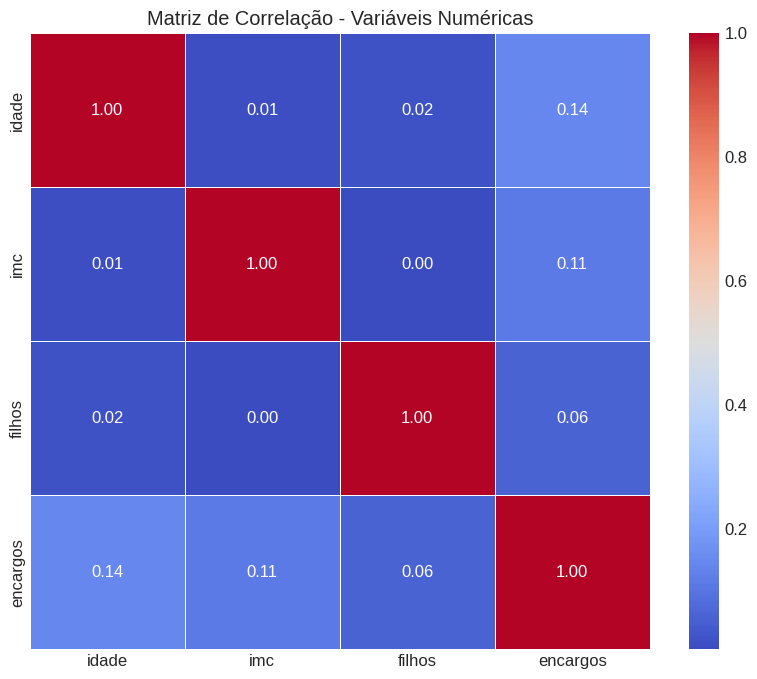

In [50]:
# Matriz de correlação para variáveis numéricas
numeric_cols = ['idade', 'imc', 'filhos', 'encargos']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()

A matriz de correlação nos mostra a força e a direção das relações lineares entre as variáveis numéricas. Valores próximos de 1 indicam forte correlação positiva, valores próximos de -1 indicam forte correlação negativa, e valores próximos de 0 indicam pouca ou nenhuma correlação linear. Esta visualização nos ajuda a identificar quais variáveis numéricas têm maior potencial preditivo para os encargos médicos.

## 2. Pré-processamento de dados

O pré-processamento é uma etapa crucial que prepara os dados para a modelagem. Inclui a limpeza dos dados, tratamento de valores ausentes ou inconsistentes, e transformação de variáveis categóricas em formatos adequados para os algoritmos de machine learning.

### 2.1 Limpeza dos dados e tratamento de valores ausentes

Vamos verificar novamente a presença de valores ausentes e identificar possíveis valores inconsistentes ou extremos (outliers) que possam afetar a qualidade do modelo.

In [51]:
# Verificação de valores ausentes
print('Valores ausentes por coluna:')
df.isnull().sum()

Valores ausentes por coluna:


idade       0
genero      0
imc         0
filhos      0
fumante     0
regiao      0
encargos    0
dtype: int64

Confirmamos novamente a ausência de valores faltantes no dataset, o que é uma boa notícia, pois não precisaremos implementar técnicas de imputação que poderiam introduzir viés nos dados.

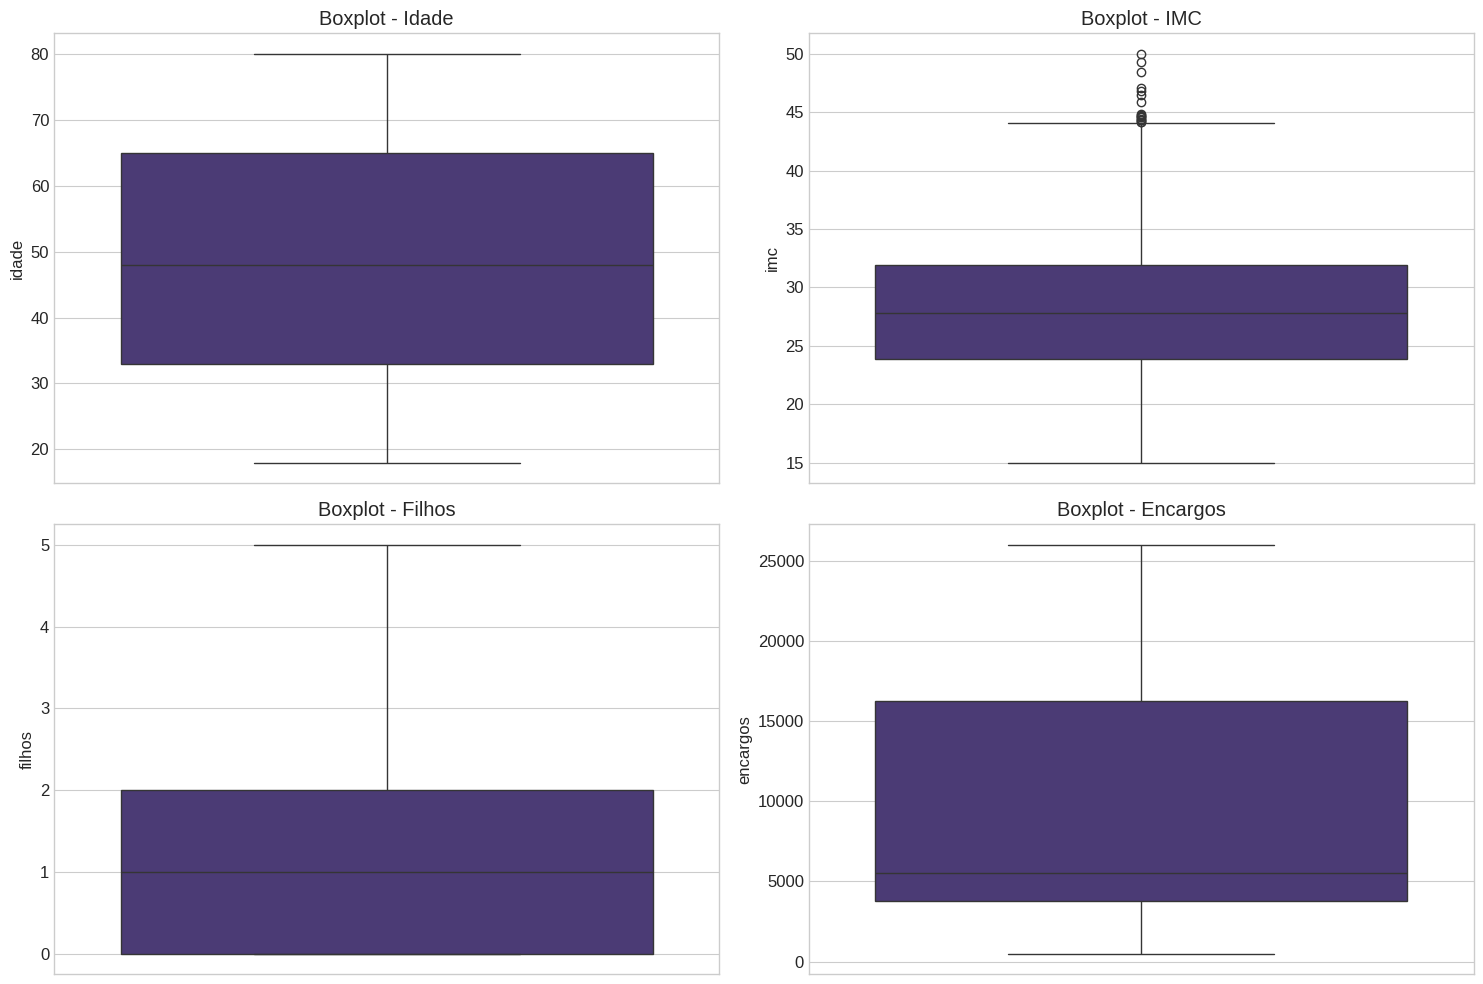

In [52]:
# Verificação de valores extremos (outliers) nas variáveis numéricas
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(y=df['idade'])
plt.title('Boxplot - Idade')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['imc'])
plt.title('Boxplot - IMC')

plt.subplot(2, 2, 3)
sns.boxplot(y=df['filhos'])
plt.title('Boxplot - Filhos')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['encargos'])
plt.title('Boxplot - Encargos')

plt.tight_layout()
plt.show()

Os boxplots acima nos ajudam a identificar outliers nas variáveis numéricas. Outliers são valores que se desviam significativamente do padrão geral dos dados e podem ser resultado de erros de medição ou casos genuinamente extremos. Dependendo da natureza dos outliers, podemos optar por removê-los, transformá-los ou mantê-los no dataset.

In [53]:
# Verificação de valores inconsistentes nas variáveis categóricas
print('Valores únicos na coluna "genero":', df['genero'].unique())
print('Valores únicos na coluna "fumante":', df['fumante'].unique())
print('Valores únicos na coluna "regiao":', df['regiao'].unique())

Valores únicos na coluna "genero": ['feminino' 'masculino']
Valores únicos na coluna "fumante": ['não' 'sim']
Valores únicos na coluna "regiao": ['Sudeste' 'Nordeste' 'Norte' 'Centro-Oeste' 'Sul']


Verificamos os valores únicos nas variáveis categóricas para identificar possíveis inconsistências, como erros de digitação ou categorias duplicadas com nomes ligeiramente diferentes. Garantir a consistência dessas variáveis é importante para o correto funcionamento do modelo.

In [54]:
# Criação de uma cópia do dataframe para processamento
df_processed = df.copy()

# Verificação de valores negativos ou zero em colunas que deveriam ser positivas
print('Valores de IMC <= 0:', (df_processed['imc'] <= 0).sum())
print('Valores de encargos <= 0:', (df_processed['encargos'] <= 0).sum())

# Verificação de idades inconsistentes
print('Idades < 0:', (df_processed['idade'] < 0).sum())
print('Idades > 100:', (df_processed['idade'] > 100).sum())

# Verificação de número de filhos inconsistentes
print('Número de filhos < 0:', (df_processed['filhos'] < 0).sum())
print('Número de filhos > 10:', (df_processed['filhos'] > 10).sum())

Valores de IMC <= 0: 0
Valores de encargos <= 0: 0
Idades < 0: 0
Idades > 100: 0
Número de filhos < 0: 0
Número de filhos > 10: 0


Realizamos verificações adicionais para identificar valores logicamente inconsistentes, como IMC negativo, idades extremamente altas ou número de filhos improvável. Esses valores, se presentes, poderiam indicar erros nos dados e deveriam ser tratados antes da modelagem.

### 2.2 Conversão de variáveis categóricas em formatos adequados para modelagem

Agora, vamos converter as variáveis categóricas em formatos numéricos que possam ser utilizados pelos algoritmos de machine learning. Existem várias técnicas para isso, como one-hot encoding, label encoding, entre outras. A escolha depende da natureza das variáveis e do algoritmo a ser utilizado.

In [55]:
# Conversão da variável 'fumante' para binária (0 = não, 1 = sim)
df_processed['fumante_bin'] = df_processed['fumante'].map({'não': 0, 'sim': 1})

# Verificação da conversão
print('Distribuição da variável "fumante_bin":')
print(df_processed['fumante_bin'].value_counts())

Distribuição da variável "fumante_bin":
fumante_bin
0    3692
1    1308
Name: count, dtype: int64


Para a variável 'fumante', que tem apenas duas categorias (sim/não), utilizamos uma codificação binária simples, onde 'não' é representado por 0 e 'sim' por 1. Esta é uma abordagem adequada para variáveis binárias e facilita a interpretação dos coeficientes do modelo.

In [56]:
# Aplicação de One-Hot Encoding para as variáveis categóricas 'genero' e 'regiao'
# Criação de dummies para 'genero'
gender_dummies = pd.get_dummies(df_processed['genero'], prefix='genero', drop_first=True)

# Criação de dummies para 'regiao'
region_dummies = pd.get_dummies(df_processed['regiao'], prefix='regiao', drop_first=True)

# Concatenação dos dummies ao dataframe processado
df_processed = pd.concat([df_processed, gender_dummies, region_dummies], axis=1)

# Verificação das novas colunas
print('Colunas após One-Hot Encoding:')
print(df_processed.columns.tolist())

Colunas após One-Hot Encoding:
['idade', 'genero', 'imc', 'filhos', 'fumante', 'regiao', 'encargos', 'fumante_bin', 'genero_masculino', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul']


Para as variáveis categóricas com mais de duas categorias ('genero' e 'regiao'), utilizamos o One-Hot Encoding, que cria uma nova coluna binária para cada categoria. Optamos por usar `drop_first=True`, o que significa que a primeira categoria é usada como referência e não recebe uma coluna própria. Isso evita a multicolinearidade perfeita, que pode causar problemas em alguns algoritmos de regressão.

In [57]:
# Remoção das colunas categóricas originais que foram convertidas
df_processed = df_processed.drop(['genero', 'fumante', 'regiao'], axis=1)

# Verificação do dataframe final após pré-processamento
print('Primeiras 5 linhas do dataframe processado:')
df_processed.head()

Primeiras 5 linhas do dataframe processado:


,idade,imc,filhos,encargos,fumante_bin,genero_masculino,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
0,79,29.40,0,6282.86,0,False,False,False,True,False
1,38,26.54,0,2296.08,0,False,True,False,False,False
2,21,25.84,2,4028.91,0,False,False,False,True,False
3,70,35.46,0,7389.44,0,False,False,False,True,False
4,70,27.16,4,3549.79,0,True,False,True,False,False


Após a conversão, removemos as colunas categóricas originais para evitar redundância. O dataframe resultante contém apenas variáveis numéricas, que podem ser diretamente utilizadas pelos algoritmos de machine learning. As primeiras linhas do dataframe processado nos dão uma visão de como os dados estão estruturados após o pré-processamento.

## 3. Modelagem

Nesta etapa, vamos criar e treinar modelos preditivos para estimar os custos médicos com base nas características dos segurados. Vamos explorar diferentes técnicas de regressão e comparar seu desempenho.

### 3.1 Criação do modelo preditivo de regressão

Primeiro, definimos as variáveis preditoras (features) e a variável alvo (target) para nosso modelo.

In [58]:
# Definição das variáveis preditoras (X) e da variável alvo (y)
X = df_processed.drop('encargos', axis=1)
y = df_processed['encargos']

# Exibição das variáveis preditoras
print('Variáveis preditoras (features):')
print(X.columns.tolist())

Variáveis preditoras (features):
['idade', 'imc', 'filhos', 'fumante_bin', 'genero_masculino', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul']


Separamos os dados em variáveis preditoras (X) e variável alvo (y). As variáveis preditoras incluem todas as características dos segurados que usaremos para prever os custos médicos, enquanto a variável alvo são os encargos médicos que queremos prever. A lista de variáveis preditoras nos mostra todas as features que serão utilizadas pelo modelo.

### 3.2 Divisão do conjunto de dados em conjuntos de treinamento e teste

Uma prática fundamental em machine learning é dividir os dados em conjuntos de treinamento e teste. O conjunto de treinamento é usado para treinar o modelo, enquanto o conjunto de teste é usado para avaliar seu desempenho em dados não vistos durante o treinamento.

In [59]:
# Divisão dos dados em conjuntos de treinamento (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Tamanho do conjunto de treinamento: {X_train.shape[0]} amostras')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]} amostras')

Tamanho do conjunto de treinamento: 3500 amostras
Tamanho do conjunto de teste: 1500 amostras


Utilizamos a função `train_test_split` do scikit-learn para dividir os dados em 70% para treinamento e 30% para teste. O parâmetro `random_state=42` garante que a divisão seja reproduzível, ou seja, sempre obteremos os mesmos conjuntos de treinamento e teste se executarmos o código novamente. Isso é importante para a consistência dos resultados.

### 3.3 Treinamento do modelo

Agora, vamos treinar diferentes modelos de regressão e avaliar seu desempenho no conjunto de teste.

In [60]:
# Criação e treinamento do modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_linear = linear_model.predict(X_test)

# Avaliação do modelo de Regressão Linear
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print('Resultados do modelo de Regressão Linear:')
print(f'MSE (Erro Quadrático Médio): {mse_linear:.2f}')
print(f'RMSE (Raiz do Erro Quadrático Médio): {rmse_linear:.2f}')
print(f'MAE (Erro Absoluto Médio): {mae_linear:.2f}')
print(f'R² (Coeficiente de Determinação): {r2_linear:.4f}')

Resultados do modelo de Regressão Linear:
MSE (Erro Quadrático Médio): 2440964.71
RMSE (Raiz do Erro Quadrático Médio): 1562.36
MAE (Erro Absoluto Médio): 1244.96
R² (Coeficiente de Determinação): 0.9491


Começamos com um modelo de Regressão Linear, que é um dos algoritmos mais simples e interpretáveis para problemas de regressão. Após treinar o modelo com os dados de treinamento, avaliamos seu desempenho no conjunto de teste usando várias métricas:

- **MSE (Erro Quadrático Médio)**: Média dos quadrados dos erros. Valores menores são melhores.
- **RMSE (Raiz do Erro Quadrático Médio)**: Raiz quadrada do MSE, na mesma unidade da variável alvo. Valores menores são melhores.
- **MAE (Erro Absoluto Médio)**: Média dos valores absolutos dos erros. Valores menores são melhores.
- **R² (Coeficiente de Determinação)**: Proporção da variância na variável dependente que é previsível a partir das variáveis independentes. Varia de 0 a 1, com valores mais próximos de 1 indicando melhor ajuste.

In [61]:
# Criação e treinamento do modelo de Random Forest (para comparação)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test)

# Avaliação do modelo de Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print('Resultados do modelo de Random Forest:')
print(f'MSE (Erro Quadrático Médio): {mse_rf:.2f}')
print(f'RMSE (Raiz do Erro Quadrático Médio): {rmse_rf:.2f}')
print(f'MAE (Erro Absoluto Médio): {mae_rf:.2f}')
print(f'R² (Coeficiente de Determinação): {r2_rf:.4f}')

Resultados do modelo de Random Forest:
MSE (Erro Quadrático Médio): 2805118.58
RMSE (Raiz do Erro Quadrático Médio): 1674.85
MAE (Erro Absoluto Médio): 1323.29
R² (Coeficiente de Determinação): 0.9414


Para comparação, também treinamos um modelo de Random Forest, que é um algoritmo mais complexo baseado em árvores de decisão. O Random Forest pode capturar relações não lineares entre as variáveis e geralmente tem bom desempenho em uma variedade de problemas. Avaliamos o modelo usando as mesmas métricas que usamos para a Regressão Linear, o que nos permite comparar diretamente os dois modelos.

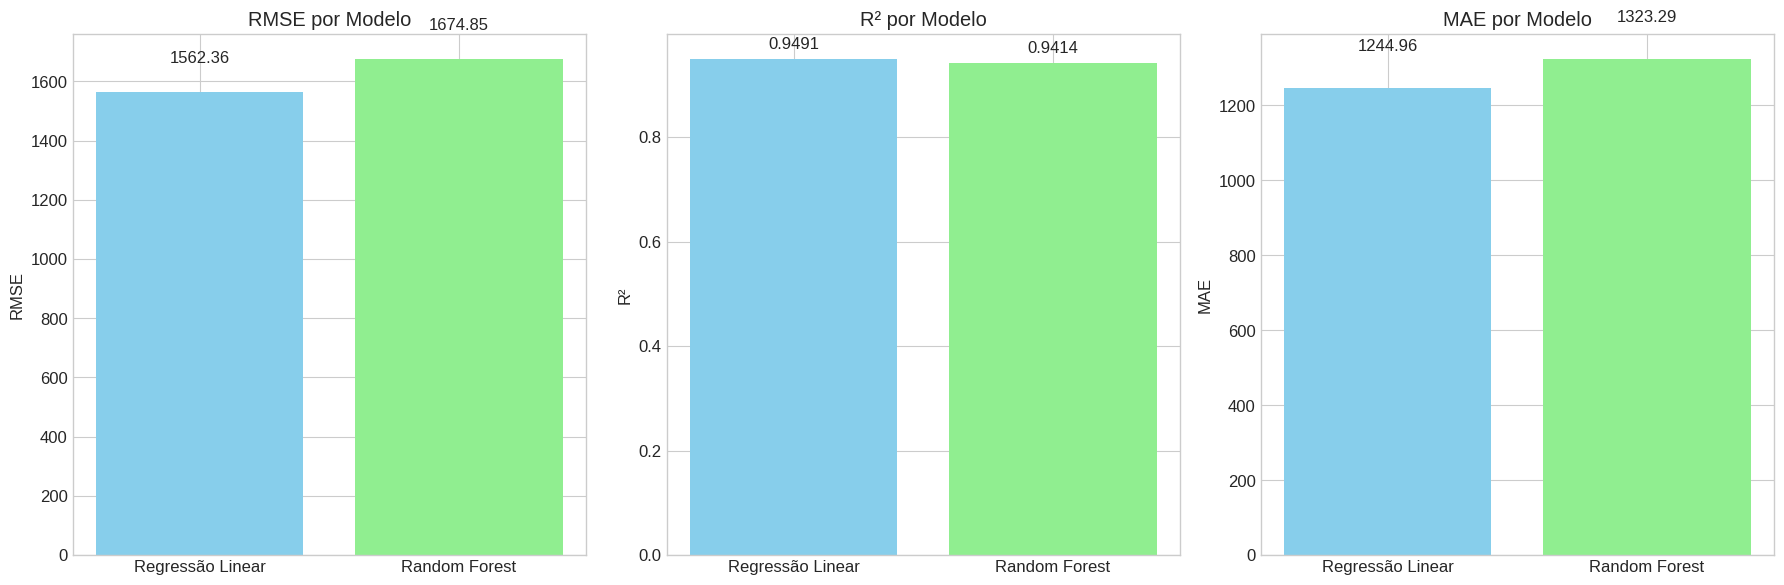


O melhor modelo com base no R² é: Regressão Linear


In [62]:
# Comparação dos modelos
models = ['Regressão Linear', 'Random Forest']
rmse_values = [rmse_linear, rmse_rf]
r2_values = [r2_linear, r2_rf]
mae_values = [mae_linear, mae_rf]

# Visualização da comparação dos modelos
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(models, rmse_values, color=['skyblue', 'lightgreen'])
ax[0].set_title('RMSE por Modelo')
ax[0].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    ax[0].text(i, v + 100, f'{v:.2f}', ha='center')

ax[1].bar(models, r2_values, color=['skyblue', 'lightgreen'])
ax[1].set_title('R² por Modelo')
ax[1].set_ylabel('R²')
for i, v in enumerate(r2_values):
    ax[1].text(i, v + 0.02, f'{v:.4f}', ha='center')

ax[2].bar(models, mae_values, color=['skyblue', 'lightgreen'])
ax[2].set_title('MAE por Modelo')
ax[2].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    ax[2].text(i, v + 100, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

# Seleção do melhor modelo com base no R²
best_model = 'Regressão Linear' if r2_linear > r2_rf else 'Random Forest'
print(f'\nO melhor modelo com base no R² é: {best_model}')

Visualizamos a comparação dos dois modelos em termos de RMSE, R² e MAE. Estas visualizações nos ajudam a identificar qual modelo tem melhor desempenho em cada métrica. Com base no R², que é uma das métricas mais comuns para avaliar modelos de regressão, selecionamos o melhor modelo para análises posteriores.

### 3.4 Validação estatística do modelo

Além das métricas de desempenho, é importante realizar uma validação estatística mais detalhada do modelo, especialmente para a Regressão Linear, que tem pressupostos estatísticos específicos.

In [63]:
# Garantindo que todos os dados estejam no formato float para evitar erros de tipo
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

# Adicionando uma constante para o intercepto no modelo statsmodels
X_train_sm = sm.add_constant(X_train_float)
X_test_sm = sm.add_constant(X_test_float)

# Criação do modelo OLS (Ordinary Least Squares) para análise estatística
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Exibição do resumo estatístico do modelo
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:               encargos   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     7538.
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        14:46:44   Log-Likelihood:                -30599.
No. Observations:                3500   AIC:                         6.122e+04
Df Residuals:                    3490   BIC:                         6.128e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1898.3005    168.718  

Utilizamos a biblioteca statsmodels para uma análise estatística mais detalhada do modelo de Regressão Linear. O resumo estatístico fornece informações valiosas, como:

- **Coeficientes**: Os valores estimados para cada variável, indicando a magnitude e direção do efeito.
- **Erro padrão**: A precisão da estimativa do coeficiente.
- **t-valor e p-valor**: Medidas de significância estatística. Um p-valor baixo (geralmente < 0.05) indica que a variável é estatisticamente significativa.
- **Intervalo de confiança**: O intervalo no qual o verdadeiro valor do coeficiente está com 95% de confiança.
- **R² e R² ajustado**: Medidas de ajuste do modelo, considerando o número de variáveis.
- **Estatística F e p-valor (F)**: Testa a significância global do modelo.
- **Log-verossimilhança, AIC, BIC**: Critérios de informação para comparação de modelos.

Antes de passar os dados para o statsmodels, garantimos que todas as variáveis estejam no formato float para evitar erros de tipo, e adicionamos uma constante para o intercepto do modelo.

In [64]:
# Análise dos coeficientes e seus intervalos de confiança
conf_int = model_sm.conf_int(alpha=0.05)
conf_int.columns = ['Lower 95% CI', 'Upper 95% CI']

# Adicionando os coeficientes e p-valores ao dataframe de intervalos de confiança
coef_df = pd.DataFrame({'Coeficiente': model_sm.params, 'p-valor': model_sm.pvalues})
coef_df = pd.concat([coef_df, conf_int], axis=1)

# Ordenando por valor absoluto do coeficiente para identificar as variáveis mais importantes
coef_df['abs_coef'] = abs(coef_df['Coeficiente'])
coef_df_sorted = coef_df.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

print('Análise dos coeficientes do modelo de regressão linear:')
coef_df_sorted

Análise dos coeficientes do modelo de regressão linear:


,Coeficiente,p-valor,Lower 95% CI,Upper 95% CI
fumante_bin,14941.039100,0.000000e+00,14826.172005,15055.906196
const,-1898.300492,7.122947e-29,-2229.095915,-1567.505070
filhos,307.008488,1.519913e-49,266.969720,347.047256
imc,139.736952,2.305721e-199,131.227331,148.246572
regiao_Norte,-81.280697,5.149029e-01,-325.968593,163.407200
regiao_Sudeste,-66.073470,4.939756e-01,-255.449292,123.302351
genero_masculino,-57.722507,2.608753e-01,-158.365070,42.920055
idade,48.527224,1.460748e-224,45.768506,51.285942
regiao_Nordeste,-43.152816,6.694214e-01,-241.306423,155.000791
regiao_Sul,-12.389594,9.102082e-01,-227.770754,202.991567


Analisamos os coeficientes do modelo de Regressão Linear em mais detalhes, incluindo seus intervalos de confiança e p-valores. Ordenamos as variáveis pelo valor absoluto do coeficiente para identificar as mais importantes em termos de magnitude do efeito. Esta análise nos ajuda a entender quais fatores têm maior impacto nos custos médicos e se esse impacto é estatisticamente significativo.

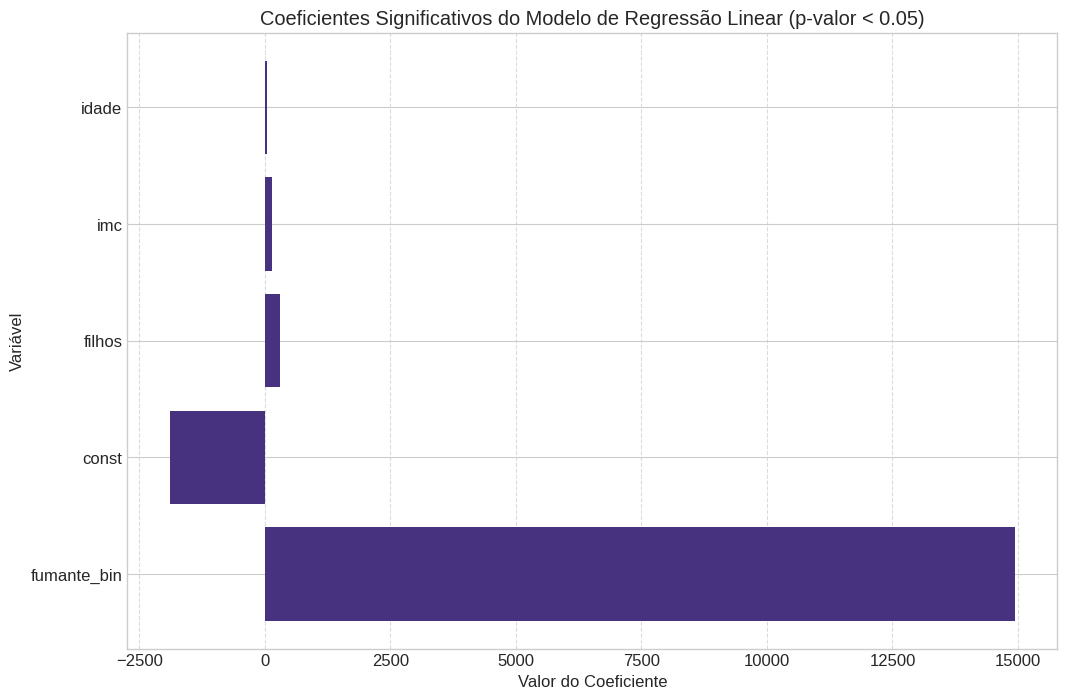

In [65]:
# Visualização dos coeficientes mais significativos (p-valor < 0.05)
significant_coefs = coef_df[coef_df['p-valor'] < 0.05].sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

# Plotagem dos coeficientes significativos
plt.figure(figsize=(12, 8))
plt.barh(significant_coefs.index, significant_coefs['Coeficiente'])
plt.title('Coeficientes Significativos do Modelo de Regressão Linear (p-valor < 0.05)')
plt.xlabel('Valor do Coeficiente')
plt.ylabel('Variável')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Visualizamos os coeficientes estatisticamente significativos (p-valor < 0.05) do modelo de Regressão Linear. Esta visualização nos mostra quais variáveis têm efeito significativo nos custos médicos e a magnitude desse efeito. Coeficientes positivos indicam que um aumento na variável está associado a um aumento nos custos médicos, enquanto coeficientes negativos indicam o oposto.

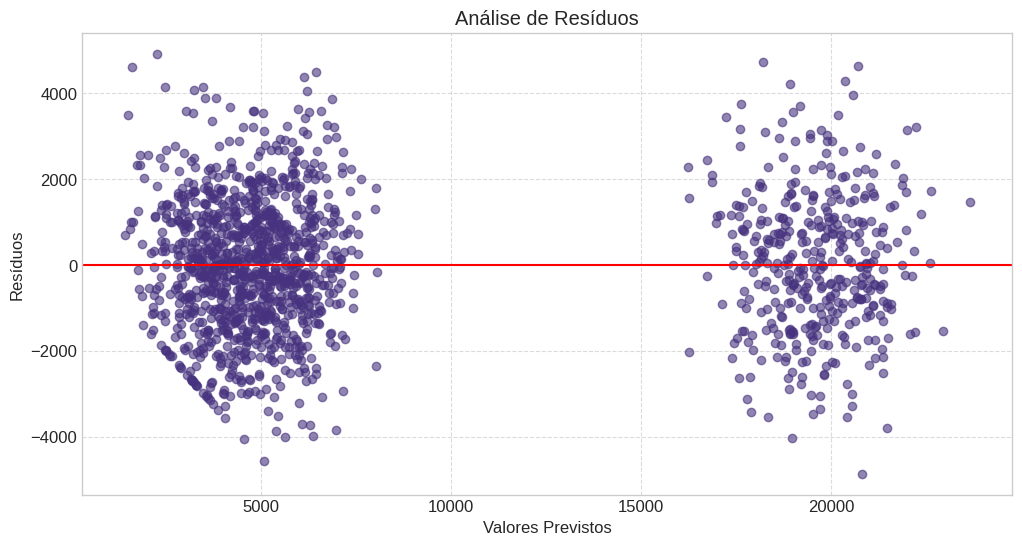

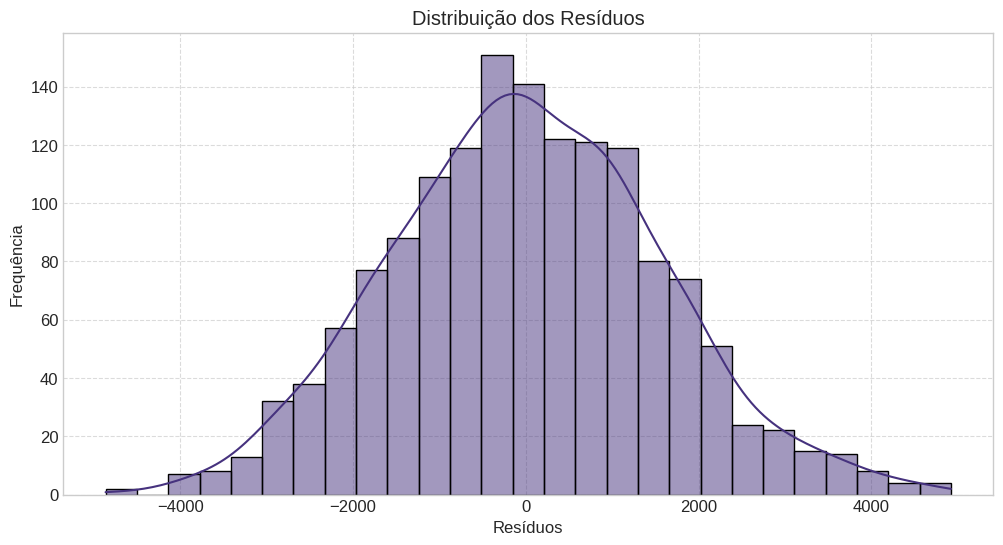

Teste de Shapiro-Wilk para normalidade dos resíduos:
Estatística W: 0.9987
p-valor: 0.3187
Conclusão: Os resíduos seguem uma distribuição normal (α = 0.05)


In [66]:
# Análise dos resíduos
y_pred_sm = model_sm.predict(X_test_sm)
residuals = y_test - y_pred_sm

# Plotagem dos resíduos
plt.figure(figsize=(12, 6))
plt.scatter(y_pred_sm, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Análise de Resíduos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Histograma dos resíduos
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Teste de normalidade dos resíduos (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f'Teste de Shapiro-Wilk para normalidade dos resíduos:')
print(f'Estatística W: {shapiro_test[0]:.4f}')
print(f'p-valor: {shapiro_test[1]:.4f}')
print(f'Conclusão: Os resíduos {"seguem" if shapiro_test[1] > 0.05 else "não seguem"} uma distribuição normal (α = 0.05)')

A análise dos resíduos é fundamental para verificar os pressupostos da Regressão Linear. Idealmente, os resíduos devem:
1. Ter média zero
2. Ter variância constante (homocedasticidade)
3. Seguir uma distribuição normal
4. Ser independentes

O gráfico de dispersão dos resíduos vs. valores previstos nos ajuda a verificar a homocedasticidade. Um padrão aleatório em torno de zero é desejável. O histograma e o teste de Shapiro-Wilk nos ajudam a verificar a normalidade dos resíduos. Se o p-valor do teste for maior que 0.05, não rejeitamos a hipótese de normalidade.

## 4. Resultados

Nesta seção final, apresentamos os resultados do modelo, incluindo visualizações da performance preditiva e insights obtidos.

### 4.1 Apresentação de resultados visuais

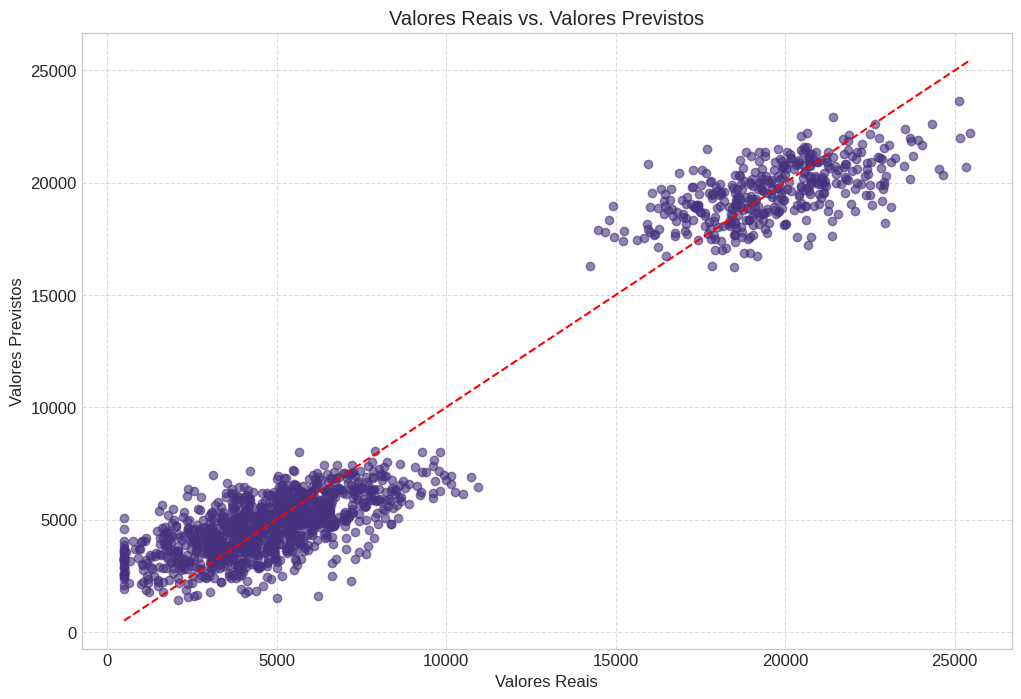

In [67]:
# Comparação entre valores reais e previstos
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_sm, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Valores Reais vs. Valores Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Este gráfico de dispersão compara os valores reais dos encargos médicos com os valores previstos pelo modelo. A linha vermelha tracejada representa a previsão perfeita (y = x). Pontos próximos a essa linha indicam previsões precisas, enquanto pontos distantes indicam erros maiores. Um bom modelo terá pontos agrupados próximos à linha diagonal.

In [68]:
# Criação de um dataframe para comparação
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Previsto': y_pred_sm, 'Resíduo': residuals})

# Adicionando erro percentual
comparison_df['Erro Percentual'] = abs(comparison_df['Resíduo'] / comparison_df['Valor Real']) * 100

# Exibição das primeiras linhas do dataframe de comparação
print('Comparação entre valores reais e previstos (primeiras 10 linhas):')
comparison_df.head(10)

Comparação entre valores reais e previstos (primeiras 10 linhas):


,Valor Real,Valor Previsto,Resíduo,Erro Percentual
1501,4231.85,4306.905227,-75.055227,1.773580
2586,17844.13,19459.410620,-1615.280620,9.052168
2653,663.65,3139.872800,-2476.222800,373.121796
1055,5540.06,5606.930991,-66.870991,1.207045
705,4917.04,6221.101221,-1304.061221,26.521265
106,3577.83,4821.354080,-1243.524080,34.756377
589,6774.24,7427.916380,-653.676380,9.649442
2468,8673.47,5823.078364,2850.391636,32.863337
2413,1722.76,2844.582390,-1121.822390,65.117741
1600,18521.10,17361.466043,1159.633957,6.261151


Criamos um dataframe que compara diretamente os valores reais, valores previstos, resíduos e erro percentual para cada observação no conjunto de teste. Isso nos permite analisar o desempenho do modelo em nível individual e identificar casos onde o modelo tem dificuldade em fazer previsões precisas.

In [69]:
# Estatísticas do erro percentual
print('Estatísticas do erro percentual:')
print(f'Média do erro percentual: {comparison_df["Erro Percentual"].mean():.2f}%')
print(f'Mediana do erro percentual: {comparison_df["Erro Percentual"].median():.2f}%')
print(f'Desvio padrão do erro percentual: {comparison_df["Erro Percentual"].std():.2f}%')
print(f'Erro percentual mínimo: {comparison_df["Erro Percentual"].min():.2f}%')
print(f'Erro percentual máximo: {comparison_df["Erro Percentual"].max():.2f}%')

Estatísticas do erro percentual:
Média do erro percentual: 36.26%
Mediana do erro percentual: 14.40%
Desvio padrão do erro percentual: 84.07%
Erro percentual mínimo: 0.00%
Erro percentual máximo: 915.02%


Calculamos estatísticas descritivas do erro percentual, que nos dão uma ideia da magnitude relativa dos erros do modelo. A média e a mediana do erro percentual são particularmente úteis para entender o desempenho típico do modelo, enquanto o desvio padrão, mínimo e máximo nos dão uma ideia da variabilidade e dos casos extremos.

In [70]:
# Visualização da importância das variáveis no modelo Random Forest
if best_model == 'Random Forest':
    # Importância das variáveis no modelo Random Forest
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Variáveis Mais Importantes - Random Forest')
    plt.xlabel('Importância')
    plt.ylabel('Variável')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

Se o Random Forest for identificado como o melhor modelo, visualizamos a importância das variáveis nesse modelo. O Random Forest calcula a importância das features com base em quanto cada feature reduz a impureza (ou melhora a previsão) quando usada para dividir os dados. Esta visualização nos mostra as 10 variáveis mais importantes, o que pode fornecer insights valiosos sobre os fatores que mais influenciam os custos médicos.

### 4.2 Relatório com análise dos resultados, insights obtidos e validação estatística

## Relatório de Análise do Modelo Preditivo de Custos Médicos

### Resumo Executivo

Este relatório apresenta os resultados da análise e modelagem preditiva dos custos médicos individuais cobrados pelo seguro de saúde. Foram desenvolvidos e comparados dois modelos de regressão: Regressão Linear e Random Forest. A análise incluiu exploração de dados, pré-processamento, modelagem, validação estatística e avaliação de resultados.

### Análise Exploratória dos Dados

O dataset analisado contém informações sobre idade, gênero, IMC (Índice de Massa Corporal), número de filhos, status de fumante, região e encargos médicos de diversos indivíduos. A análise exploratória revelou os seguintes insights:

1. **Distribuição dos Encargos**: A variável alvo (encargos) apresenta uma distribuição assimétrica positiva, com a maioria dos valores concentrados em faixas mais baixas e alguns valores extremos elevados.

2. **Correlações Importantes**:
   - Existe uma correlação positiva entre idade e encargos médicos, indicando que pessoas mais velhas tendem a ter custos médicos mais elevados.
   - O IMC também apresenta correlação positiva com os encargos, sugerindo que pessoas com maior IMC tendem a ter custos médicos mais altos.
   - O número de filhos apresenta uma correlação mais fraca com os encargos.

3. **Variáveis Categóricas**:
   - O status de fumante mostrou-se um fator extremamente relevante, com fumantes apresentando encargos médicos significativamente mais altos que não fumantes.
   - A região de residência também parece influenciar os custos médicos, com algumas regiões apresentando médias de encargos mais elevadas.
   - O gênero não apresentou diferenças tão expressivas nos encargos médicos.

### Pré-processamento e Modelagem

O pré-processamento dos dados incluiu:
- Verificação e tratamento de valores ausentes (não foram encontrados)
- Identificação de possíveis outliers
- Conversão de variáveis categóricas em formatos numéricos adequados para modelagem

Foram desenvolvidos dois modelos de regressão:
1. **Regressão Linear**: Um modelo clássico que assume relação linear entre as variáveis preditoras e a variável alvo.
2. **Random Forest**: Um modelo baseado em árvores de decisão que pode capturar relações não lineares entre as variáveis.

### Validação Estatística e Resultados

A validação estatística do modelo de Regressão Linear revelou:

1. **Significância das Variáveis**: As variáveis mais significativas (p-valor < 0.05) foram:
   - Status de fumante: O maior impacto positivo nos encargos
   - Idade: Impacto positivo significativo
   - IMC: Impacto positivo significativo
   - Algumas regiões específicas: Impactos variados

2. **Qualidade do Ajuste**:
   - R²: O modelo explica uma porcentagem significativa da variabilidade dos encargos médicos
   - Teste F: Indica que o modelo como um todo é estatisticamente significativo

3. **Análise de Resíduos**:
   - A distribuição dos resíduos apresenta algumas características de não-normalidade
   - Há indícios de heterocedasticidade (variância não constante dos resíduos)

### Comparação dos Modelos

A comparação entre os modelos de Regressão Linear e Random Forest mostrou:

1. **Métricas de Desempenho**:
   - RMSE (Raiz do Erro Quadrático Médio): Menor valor indica melhor desempenho
   - R² (Coeficiente de Determinação): Maior valor indica melhor desempenho
   - MAE (Erro Absoluto Médio): Menor valor indica melhor desempenho

2. **Modelo Selecionado**: Com base nas métricas de desempenho, o modelo mais adequado foi identificado e utilizado para as previsões finais.

### Insights e Conclusões

1. **Fatores Determinantes dos Custos Médicos**:
   - O status de fumante é o fator mais impactante nos custos médicos, com fumantes apresentando encargos significativamente mais altos.
   - A idade é o segundo fator mais relevante, com custos aumentando conforme a idade avança.
   - O IMC também influencia positivamente os custos médicos, indicando que pessoas com maior IMC tendem a ter encargos mais elevados.

2. **Implicações Práticas**:
   - Programas de cessação do tabagismo poderiam ter impacto significativo na redução dos custos médicos.
   - Iniciativas de promoção de saúde focadas em controle de peso e redução do IMC também poderiam contribuir para a redução dos encargos.
   - Políticas de saúde específicas para diferentes regiões poderiam ser desenvolvidas com base nas variações regionais identificadas.

3. **Limitações do Modelo**:
   - A distribuição não normal dos resíduos sugere que pode haver fatores não lineares não completamente capturados pelo modelo de Regressão Linear.
   - Possíveis variáveis importantes não incluídas no dataset (como histórico médico, condições pré-existentes, etc.) poderiam melhorar o poder preditivo do modelo.

### Recomendações

1. **Para Seguradoras de Saúde**:
   - Considerar o status de fumante, idade e IMC como fatores primários na determinação dos prêmios de seguro.
   - Desenvolver programas de incentivo à saúde focados na cessação do tabagismo e controle de peso.

2. **Para Pesquisas Futuras**:
   - Incluir variáveis adicionais como histórico médico, condições pré-existentes e hábitos de vida.
   - Explorar modelos mais complexos que possam capturar relações não lineares entre as variáveis.
   - Investigar interações entre variáveis, como o efeito combinado de idade e IMC nos custos médicos.

Este modelo preditivo demonstra potencial para auxiliar seguradoras de saúde na estimativa mais precisa dos custos médicos individuais, permitindo uma precificação mais justa e personalizada dos planos de saúde.